In [129]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import os
import re
import numpy as np
import seaborn
import tensorflow as tf
import datetime
import time
from shutil import copyfile

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score

%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def projection_on_set(vector, set_of_vectors):
    projection_vector = np.zeros(*vector.shape) 
    for ort_vector in set_of_vectors:
        projection_vector += np.dot(vector, ort_vector) / np.linalg.norm(ort_vector) * ort_vector
    return projection_vector

In [10]:
import AnonymousWalkEmbeddings, AnonymousWalkKernel, func_tools

In [11]:
reload(AnonymousWalkEmbeddings)

<module 'AnonymousWalkEmbeddings' from 'AnonymousWalkEmbeddings.pyc'>

In [12]:
reload(AnonymousWalkKernel)

<module 'AnonymousWalkKernel' from 'AnonymousWalkKernel.pyc'>

# Детектирование аномалий в потоках графов 

## Описание 

В этом блоке будем сравнивать алгоритмы, которые могут выделять аномальные элементы в потоках графов.
Для сравнения будем использовать алгоритмы [ParCube](#parcube), [DeltaCon](#deltacon), [Concept Drift and Anomaly Detection in Graph Streams](#cdadgs) и [наш](#ref) алгоритм

Будем проводить эксперименты на датасете [TwitterSecurity2014](http://odds.cs.stonybrook.edu/twittersecurity-dataset/)
* количество нод ~ 130 к
* количество таймстемпов ~ 120 
* 20 аномальных дней 

Сам датасет состоит из строк вида: user_1 user_2 number_of_co-mentions

В качестве метрики для сравнения будем считать precision/recall 


<a id='parcube'></a>

## ParCube

<a id='deltacon'></a>

## DeltaCon

<a id='cdadgs'>

## Concept Drift and Anomaly Detection in Graph Streams

<a id='ref'></a>

## Reference 

Сначала пробмуем поучить модель с такими же параметрами, как на MUTAG из туториала

In [390]:
dataset = 'res_graphs'

batch_size = 100
window_size = 8
embedding_size_w = 64
embedding_size_d = 64
num_samples = 128

concat = False
loss_type = 'sampled_softmax'
optimize = 'Adagrad'
learning_rate = 1.0
root = '../enron/'
ext = 'graphml'
steps = 7
epochs = 1
batches_per_epoch = 1000
candidate_func = 'uniform'
graph_labels = None

model = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  embedding_size_w = embedding_size_w, embedding_size_d = embedding_size_d,
                  num_samples = num_samples, concat = concat, loss_type = loss_type,
                  optimize = optimize, learning_rate = learning_rate, root = root,
                  ext = ext, steps = steps, epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model.train()

Number of graphs: 455
Number of words: 877
Initialized
Epoch: 0
Graph 0: 277 nodes
Average loss at step 100: 3602.339346
Average loss at step 200: 1172.914967
Average loss at step 300: 684.647561
Average loss at step 400: 468.869386
Average loss at step 500: 390.594023
Average loss at step 600: 288.138184
Average loss at step 700: 243.335294
Average loss at step 800: 209.387005
Average loss at step 900: 203.216913
Average loss at step 1000: 172.829003
Time: 50.02439785
Graph 1: 274 nodes
Average loss at step 1100: 303.022395
Average loss at step 1200: 183.730655
Average loss at step 1300: 152.609131
Average loss at step 1400: 146.667617
Average loss at step 1500: 137.455054
Average loss at step 1600: 128.028732
Average loss at step 1700: 124.808108
Average loss at step 1800: 125.368159
Average loss at step 1900: 126.241265
Average loss at step 2000: 128.161740
Graph 2: 278 nodes
Average loss at step 2100: 148.836990
Average loss at step 2200: 94.702521
Average loss at step 2300: 94.679

# Подгрузим разметку для графов 

In [391]:
labels = open('../enron/res_graphs/labels.txt')
labels = labels.read()
labels = np.array(map(lambda x: int(x), labels.strip().split()))

In [260]:
labels1 = open('../enron/parsed_graphs/labels.txt')
labels1 = labels1.read()
labels1 = np.array(map(lambda x: int(x), labels1.strip().split()))

### PCA approximation
Здесь пробуем построить для части графов pca и потом посчитать проекции следующих эмбедингов на полученные направления. Нас интересует, как хорошо полученные проекции могут аппроксимировать сами эмбединги.

Видим, что аутлаеры не особо выбиваются из общего паттерна. Дальше попробуем посмотреть, чем можно такое поведение объяснить. 

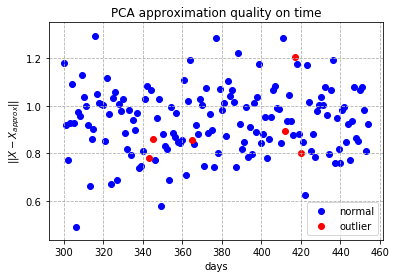

In [392]:
pca_comp_number = 300

test_set = model.graph_embeddings[:pca_comp_number]

pca = PCA(n_components=10)
pca.fit(scale(test_set))

projection_set = pca.components_[:]

res = []
for embedding in model.graph_embeddings[pca_comp_number:]:
    proj = projection_on_set(embedding, projection_set)
    res.append(np.linalg.norm(embedding - proj))
res = np.array(res)

fig = plt.figure()
plt.scatter(np.where(labels[pca_comp_number:] == 0)[0]+pca_comp_number, 
            res[np.where(labels[pca_comp_number:] == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels[pca_comp_number:] == 1)[0]+pca_comp_number, 
            res[np.where(labels[pca_comp_number:] == 1)[0]], label='outlier', c='r')
plt.xlabel("days")
plt.ylabel("$||X - X_{approx}||$")
plt.title("PCA approximation quality on time")
plt.legend()
plt.grid(ls='dashed')
#fig.savefig('graph_series_without_norm.pdf', format='pdf')

### Norm differences 

Посмотрим, как меняются векторы эмбедингов от времени. Для этого, например, можно порисовать норму разностей двух последующих векторов. Как видно из графиков какой-то хорошей шшеометрической структуры пока не получили.

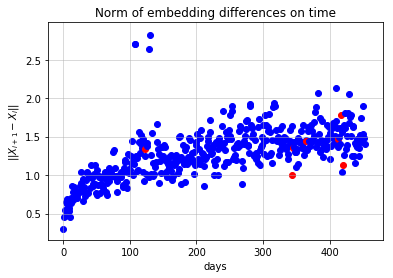

In [393]:
fig = plt.figure()
for i, label in zip(range(len(labels[:-1])), labels[:-1]):
    if label == 0:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i+1] - model.graph_embeddings[i]), c='b')
    else:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i+1] - model.graph_embeddings[i]), c='r')
    
plt.xlabel('days')
plt.ylabel('$||X_{i+1} - X_{i}||$')
plt.title("Norm of embedding differences on time")
plt.grid(alpha=0.6)
#fig.savefig('difference_embedding.pdf', format='pdf')

### Norm series 

Есть предположение о том, что аутлаеры сильно будут отличаться по норме от обычных векторов. Построим график зависимости норм векторов от времени. Получаем, что мало того, что аутлаеры не выбиваются из общей кучи, так еще необычное поведение с ростом нормы эмбедингов. Дальше попробуем разобраться, чем оно вызвано.

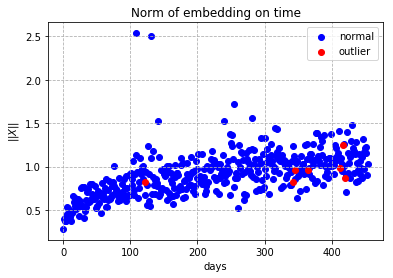

In [394]:
fig = plt.figure()
norms = np.linalg.norm(model.graph_embeddings, axis=1)

plt.scatter(np.where(labels == 0)[0], norms[np.where(labels == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels == 1)[0], norms[np.where(labels == 1)[0]], label='outlier', c='r')

plt.xlabel("days")
plt.ylabel("$||X||$")
plt.title("Norm of embedding on time")

plt.legend()
plt.grid(ls='dashed')
#fig.savefig('norms_series.pdf', format='pdf')

### Norm growth

Попробуем более отдельно рассмотреть вопрос с прошлого пункта. Интерсно, чем конкретно вызвано такое поведение у эмбедингов: либо это специфика модели, либо датасета. 

Чтобы проверить это предположение попробуем случайно помешать первые графы при обучении и снова отрисовать графики зависимости нормы от времени.

Получаем, что на самом деле такой вид графика не зависит от датасета, а относится к самой модели. Плюс к этому, вид графика завист от парметра batches_per_epoch. Чем он больше, тем более гладким получается график. При совсем мелких значениях такая зависимость нормы от времени пропадает. 

In [180]:
dataset = 'parsed_graphs'

batch_size = 100
window_size = 10
embedding_size_w = 64
embedding_size_d = 2
num_samples = 32

concat = False
loss_type = 'sampled_softmax'
optimize = 'Adagrad'
learning_rate = 1.0
root = '../enron/'
ext = 'graphml'
steps = 5
epochs = 2
batches_per_epoch = 10
candidate_func = None
graph_labels = None

model2 = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  embedding_size_w = embedding_size_w, embedding_size_d = embedding_size_d,
                  num_samples = num_samples, concat = concat, loss_type = loss_type,
                  optimize = optimize, learning_rate = learning_rate, root = root,
                  ext = ext, steps = steps, epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model2.train()

Number of graphs: 637
Number of words: 52
Initialized
Epoch: 0
Graph 0: 20 nodes
Time: 0.71936416626
Graph 1: 277 nodes
Graph 2: 274 nodes
Graph 3: 278 nodes
Graph 4: 293 nodes
Graph 5: 262 nodes
Graph 6: 9 nodes
Graph 7: 8 nodes
Graph 8: 31 nodes
Graph 9: 32 nodes
Average loss at step 100: 2627.964609
Graph 10: 264 nodes
Time: 0.589840173721
Graph 11: 229 nodes
Graph 12: 230 nodes
Graph 13: 18 nodes
Graph 14: 24 nodes
Graph 15: 306 nodes
Graph 16: 262 nodes
Graph 17: 229 nodes
Graph 18: 277 nodes
Graph 19: 200 nodes
Average loss at step 200: 606.774198
Graph 20: 16 nodes
Time: 0.440363883972
Graph 21: 12 nodes
Graph 22: 232 nodes
Graph 23: 245 nodes
Graph 24: 252 nodes
Graph 25: 207 nodes
Graph 26: 207 nodes
Graph 27: 8 nodes
Graph 28: 50 nodes
Graph 29: 249 nodes
Average loss at step 300: 235.295613
Graph 30: 263 nodes
Time: 0.569179058075
Graph 31: 237 nodes
Graph 32: 248 nodes
Graph 33: 250 nodes
Graph 34: 13 nodes
Graph 35: 45 nodes
Graph 36: 333 nodes
Graph 37: 266 nodes
Graph 38

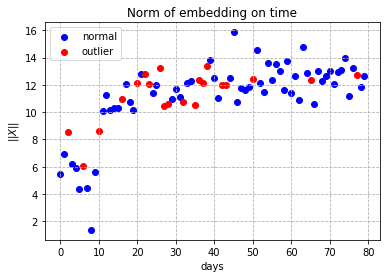

In [29]:
shuffles = ['timestep_3.graphml', 'timestep_7.graphml', 'timestep_9.graphml',
            'timestep_4.graphml', 'timestep_8.graphml', 'timestep_1.graphml', 
            'timestep_5.graphml', 'timestep_2.graphml', 'timestep_0.graphml', 
            'timestep_6.graphml']

shuffles = map(lambda x: int(x[:-8].split('_')[1]), shuffles)

fig = plt.figure()
right_order_ge = np.concatenate((model2.graph_embeddings[shuffles], model2.graph_embeddings[10:]))
norms = np.linalg.norm(right_order_ge, axis=1)

plt.scatter(np.where(labels == 0)[0], norms[np.where(labels == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels == 1)[0], norms[np.where(labels == 1)[0]], label='outlier', c='r')

plt.xlabel("days")
plt.ylabel("$||X||$")
plt.title("Norm of embedding on time")

plt.legend()
plt.grid(ls='dashed')
#fig.savefig('norms_series_shuffled.pdf', format='pdf')

### Matrix norm 


Посмотрим, что происходит с нормой матрицы слов. 

### Embeddings characteristics 

### One class SVM 

Попробуем поискать выбросы, не учитывая то, что в задаче имеется временная зависимость. Тут пробуем одноклассовый svm, в следующем пункте пробуем isolation forest

In [395]:
from sklearn.svm import OneClassSVM

In [396]:
np.where(labels == 1)

(array([122, 343, 345, 365, 412, 417, 420]),)

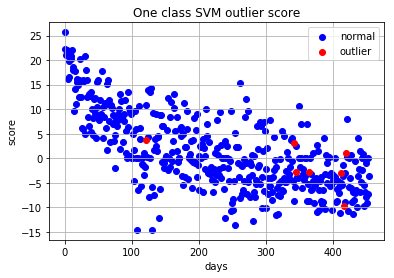

In [410]:
start, stop = 1, 500
fig = plt.figure()
cls = OneClassSVM(kernel='rbf', gamma=1.4)
cls.fit(model.graph_embeddings[np.where(labels == 0)[0]][start:stop])
plt.scatter(np.where(labels==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==0)], c='b', label='normal')
plt.scatter(np.where(labels==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==1)], c='r', label='outlier')
plt.grid()
plt.title("One class SVM outlier score")
plt.ylabel('score')
plt.xlabel('days')
plt.legend()
fig.savefig('oneclass_svm.pdf', format='pdf')  

### Isolation forest

In [411]:
from sklearn.ensemble import IsolationForest

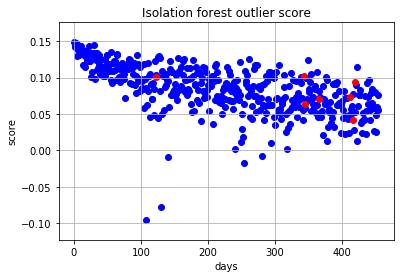

In [412]:
fig = plt.figure()
cls = IsolationForest(n_estimators=200)
cls.fit(model.graph_embeddings[np.where(labels == 0)[0]][:])
plt.scatter(np.where(labels==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==0)], c='b', label='normal')
plt.scatter(np.where(labels==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==1)], c='r', label='outlier')

plt.title("Isolation forest outlier score")
plt.ylabel('score')
plt.xlabel('days')
plt.grid()
fig.savefig('isolation_forest.pdf', format='pdf')

# Всякие разные вопросы, возникшие по ходу 

* можно ли считать AUC для такой задачи, чтобы сравнивать модели?

In [215]:
from sklearn.manifold import TSNE

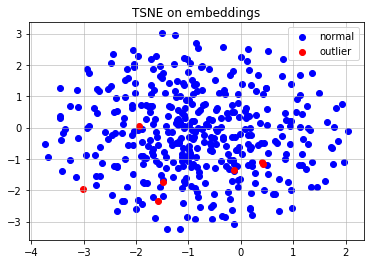

In [416]:
tsne = TSNE(perplexity=50)
start = 50
X = tsne.fit_transform(model.graph_embeddings[start:])

plt.scatter(X[np.where(labels[start:] == 0)[0], 0], X[np.where(labels[start:] == 0)[0], 1], label='normal', c='b')
plt.scatter(X[np.where(labels[start:] == 1)[0], 0], X[np.where(labels[start:] == 1)[0], 1], label='outlier', c='r')
plt.title("TSNE on embeddings")
plt.legend()
plt.grid(alpha=0.7)
#plt.scatter(norms[np.where(labels == 1)[0]], label='outlier', c='r')

In [258]:
%matplotlib notebook

KeyboardInterrupt: 

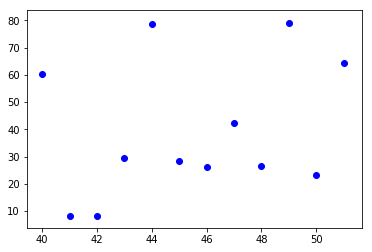

In [220]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

prev_cnt = 40
for i, label in zip(range(prev_cnt, len(labels[prev_cnt:])), labels[prev_cnt:]):
    vector_weight = 1 / np.exp(range(0, prev_cnt))
    if label == 0:
        ax.scatter(i, np.linalg.norm(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i].T.dot(vector_weight))), c='b')
    else:
        ax.scatter(i, np.linalg.norm(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i].T.dot(vector_weight))), c='r')
    fig.canvas.draw()   
    time.sleep(0.5)

/Users/Macbook/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


KeyboardInterrupt: 

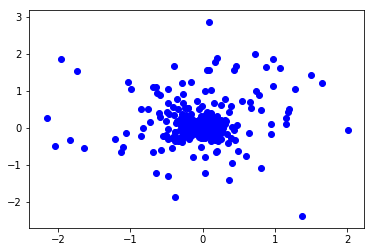

In [53]:
func_tools.iterative_drawing_2d(model, labels)

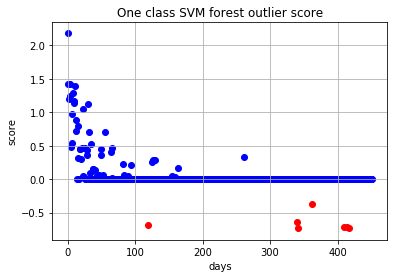

In [421]:
prev_cnt = 3
prev_dataset = []
for i, label in zip(range(prev_cnt+20, len(labels[prev_cnt:])), labels[prev_cnt:]):
    vector_weight = sum(np.exp(range(0, prev_cnt))) / np.exp(range(0, prev_cnt))
    prev_dataset.append(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i].T.dot(vector_weight)))

fig = plt.figure()
cls = OneClassSVM(kernel='rbf', gamma=5)
cls.fit(model.graph_embeddings[np.where(labels[prev_cnt:] == 0)[0]][:])
plt.scatter(np.where(labels[prev_cnt:]==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels[prev_cnt:]==0)], c='b', label='normal')
plt.scatter(np.where(labels[prev_cnt:]==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels[prev_cnt:]==1)], c='r', label='outlier')
plt.grid()
plt.title("One class SVM forest outlier score")
plt.ylabel('score')
plt.xlabel('days')
#fig.savefig('oneclass_svm.pdf', format='pdf')  

In [151]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators = 100)
cls.fit(model.graph_embeddings, labels)

ValueError: Number of labels=636 does not match number of samples=637

In [113]:
with model.graph.as_default():
    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    v = sess.run(model.word_embeddings)    
    print(np.linalg.norm(v))

193.41898


In [2]:
from scipy.io import loadmat

In [4]:
import h5py

/Users/Macbook/anaconda/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import hdf5storage
mat = hdf5storage.loadmat('enron/Date_weekend_cropped.mat')

In [9]:
emails = pd.read_csv('../enron/emails.csv')

In [45]:
r,t,y = emails.ix[100]['message'].split('\n')[1:4]

In [46]:
r.split()[2:5]

['16', 'Aug', '2000']

In [47]:
dataset = []
for i in range(len(emails)):
    
    if i%20000 == 0:
        print(i)
    
    DATE, FROM, TO = emails.ix[i]['message'].split('\n')[1:4]
    
    condition1 = DATE[:4] == 'Date' and FROM[:4] == 'From' and TO[:2] == 'To'
    condition2 = DATE[4:] != '' and FROM[4:] != '' and TO[2:] != ''
    
    try:
        dataset.append((' '.join(DATE.split()[2:5]), FROM.split()[1], TO.split()[1]))
    except IndexError:
        pass

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000


In [61]:
temp[3000][0]

'24 Jun 1999'

In [60]:
datetime.datetime.strptime(temp[3000][0], '%d %b %Y')

datetime.datetime(1999, 6, 24, 0, 0)

In [48]:
temp = sorted(dataset, key=lambda x: datetime.datetime.strptime(x[0], '%d %b %Y'))

In [62]:
def check_time(x):
    first = datetime.datetime.strptime(x[0], '%d %b %Y') > datetime.datetime(2000, 6, 24, 0, 0) 
    second = datetime.datetime.strptime(x[0], '%d %b %Y') < datetime.datetime(2002, 3, 24, 0, 0) 
    return first and second
temp1 = [x for x in temp if check_time(x)]

In [67]:
temp1 = np.array(temp1)

In [76]:
time_steps = []
for date in sorted(np.unique(temp1[:, 0]), key=lambda x: datetime.datetime.strptime(x, '%d %b %Y')):
    date_array = []
    for item in temp1:
        if item[0] == date:
            date_array.append(item)
    time_steps.append(date_array)

In [ ]:
sorted(np.unique(temp1[:, 0]), key=lambda x: datetime.datetime.strptime(x, '%d %b %Y'))

In [33]:
def sorting(x):
    print x
    return datetime.datetime.strptime(x[0], '%d %b %Y')

In [99]:
for i, step in enumerate(time_steps):
    f = open('../enron/enron_{0}.txt'.format(i), 'w')
    for line in step:
        f.write(' '.join(line[1:])+'\n')
    f.close()

In [1]:
f = open('../enron/time_steps.txt'.format(i), 'w')
for i in sorted(np.unique(temp1[:, 0]), key=lambda x: datetime.datetime.strptime(x, '%d %b %Y')):
    f.write(i + '\n')
f.close()

NameError: name 'i' is not defined

In [19]:
time_steps = []
for graph in sorted(os.listdir('../enron/graphs/')[1:], key=lambda x: int(x.split('_')[1].split('.')[0])):
    f = open('../enron/graphs/' + graph)
    lines = f.readlines()
    time_steps.append(lines)

In [22]:
z = nx.Graph()

In [34]:
z.has_edge(2,3)

False

In [31]:
z

{'weight': 2}

In [36]:
graphs = []
for time_step in time_steps:
    graph = nx.Graph()
    for line in time_step:
        FROM, TO = line.strip().split()
        if graph.has_edge(FROM, TO):
            graph[FROM][TO]['weight'] += 1
        else:
            graph.add_edge(FROM, TO, weight=1)
            
    graphs.append(graph)

In [44]:
for i, graph in enumerate(graphs):
    nx.write_graphml(graph, '../enron/parsed_graphs/enron_' + str(i) + '.graphml')

In [57]:
steps = open('../enron/time_steps.txt')
lines = steps.readlines()
steps.close()

In [58]:
steps = open('../enron/time_steps.txt', 'w')
for i, line in enumerate(lines):
    steps.write(line.strip() + '\t' + str(i) + '\n')
steps.close()

In [62]:
labels = np.zeros(636)
for i in [171, 480, 484, 512, 577, 584, 589]:
    labels[i] = 1

In [68]:
f = open('../enron/parsed_graphs/labels.txt', 'w')

In [69]:
for i in labels:
    print i
    f.write(str(int(i)) + ' ')
f.close()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [98]:
f = open('../enron/time_steps.txt')
lines = f.readlines()

['25 Jun 2000\t0\n',
 '26 Jun 2000\t1\n',
 '27 Jun 2000\t2\n',
 '28 Jun 2000\t3\n',
 '29 Jun 2000\t4\n',
 '30 Jun 2000\t5\n',
 '1 Jul 2000\t6\n',
 '2 Jul 2000\t7\n',
 '3 Jul 2000\t8\n',
 '4 Jul 2000\t9\n',
 '5 Jul 2000\t10\n',
 '6 Jul 2000\t11\n',
 '7 Jul 2000\t12\n',
 '8 Jul 2000\t13\n',
 '9 Jul 2000\t14\n',
 '10 Jul 2000\t15\n',
 '11 Jul 2000\t16\n',
 '12 Jul 2000\t17\n',
 '13 Jul 2000\t18\n',
 '14 Jul 2000\t19\n',
 '15 Jul 2000\t20\n',
 '16 Jul 2000\t21\n',
 '17 Jul 2000\t22\n',
 '18 Jul 2000\t23\n',
 '19 Jul 2000\t24\n',
 '20 Jul 2000\t25\n',
 '21 Jul 2000\t26\n',
 '22 Jul 2000\t27\n',
 '23 Jul 2000\t28\n',
 '24 Jul 2000\t29\n',
 '25 Jul 2000\t30\n',
 '26 Jul 2000\t31\n',
 '27 Jul 2000\t32\n',
 '28 Jul 2000\t33\n',
 '29 Jul 2000\t34\n',
 '30 Jul 2000\t35\n',
 '31 Jul 2000\t36\n',
 '1 Aug 2000\t37\n',
 '2 Aug 2000\t38\n',
 '3 Aug 2000\t39\n',
 '4 Aug 2000\t40\n',
 '5 Aug 2000\t41\n',
 '6 Aug 2000\t42\n',
 '7 Aug 2000\t43\n',
 '8 Aug 2000\t44\n',
 '9 Aug 2000\t45\n',
 '10 Aug 2000\t4

In [145]:
temp = map(lambda x: x.split()[-1], lines)

In [120]:
temp = [x for i, x in list(enumerate(temp)) if i % 6 != 0 and i % 7 != 0]

In [151]:
sunday = temp[0::7]

In [153]:
saturday = temp[6::7] 

In [158]:
dayoffs = map(lambda x: int(x), sunday + saturday)

In [160]:
temp = map(lambda x: int(x), temp)

In [163]:
temp = [x for x in temp if x not in dayoffs]

In [164]:
temp

[1,
 2,
 3,
 4,
 5,
 8,
 9,
 10,
 11,
 12,
 15,
 16,
 17,
 18,
 19,
 22,
 23,
 24,
 25,
 26,
 29,
 30,
 31,
 32,
 33,
 36,
 37,
 38,
 39,
 40,
 43,
 44,
 45,
 46,
 47,
 50,
 51,
 52,
 53,
 54,
 57,
 58,
 59,
 60,
 61,
 64,
 65,
 66,
 67,
 68,
 71,
 72,
 73,
 74,
 75,
 78,
 79,
 80,
 81,
 82,
 85,
 86,
 87,
 88,
 89,
 92,
 93,
 94,
 95,
 96,
 99,
 100,
 101,
 102,
 103,
 106,
 107,
 108,
 109,
 110,
 113,
 114,
 115,
 116,
 117,
 120,
 121,
 122,
 123,
 124,
 127,
 128,
 129,
 130,
 131,
 134,
 135,
 136,
 137,
 138,
 141,
 142,
 143,
 144,
 145,
 148,
 149,
 150,
 151,
 152,
 155,
 156,
 157,
 158,
 159,
 162,
 163,
 164,
 165,
 166,
 169,
 170,
 171,
 172,
 173,
 176,
 177,
 178,
 179,
 180,
 183,
 184,
 185,
 186,
 187,
 190,
 191,
 192,
 193,
 194,
 197,
 198,
 199,
 200,
 201,
 204,
 205,
 206,
 207,
 208,
 211,
 212,
 213,
 214,
 215,
 218,
 219,
 220,
 221,
 222,
 225,
 226,
 227,
 228,
 229,
 232,
 233,
 234,
 235,
 236,
 239,
 240,
 241,
 242,
 243,
 246,
 247,
 248,
 249,
 250

In [165]:
files = os.listdir('../enron/parsed_graphs/')

In [166]:
files = files[1:-1]

In [168]:
new_files = [x for x in files if int(x.split('.')[0].split('_')[1]) in temp]

In [170]:
for f in new_files:
    copyfile('../enron/parsed_graphs/'+f, '../enron/res_graphs/'+f)

In [181]:
t = [True if i not in dayoffs else False for i in range(len(files)) ]

In [188]:
files

['enron_0.graphml',
 'enron_1.graphml',
 'enron_10.graphml',
 'enron_100.graphml',
 'enron_101.graphml',
 'enron_102.graphml',
 'enron_103.graphml',
 'enron_104.graphml',
 'enron_105.graphml',
 'enron_106.graphml',
 'enron_107.graphml',
 'enron_108.graphml',
 'enron_109.graphml',
 'enron_11.graphml',
 'enron_110.graphml',
 'enron_111.graphml',
 'enron_112.graphml',
 'enron_113.graphml',
 'enron_114.graphml',
 'enron_115.graphml',
 'enron_116.graphml',
 'enron_117.graphml',
 'enron_118.graphml',
 'enron_119.graphml',
 'enron_12.graphml',
 'enron_120.graphml',
 'enron_121.graphml',
 'enron_122.graphml',
 'enron_123.graphml',
 'enron_124.graphml',
 'enron_125.graphml',
 'enron_126.graphml',
 'enron_127.graphml',
 'enron_128.graphml',
 'enron_129.graphml',
 'enron_13.graphml',
 'enron_130.graphml',
 'enron_131.graphml',
 'enron_132.graphml',
 'enron_133.graphml',
 'enron_134.graphml',
 'enron_135.graphml',
 'enron_136.graphml',
 'enron_137.graphml',
 'enron_138.graphml',
 'enron_139.graphm

In [192]:
c = open('../enron/time_steps.txt')
q = c.readlines()
c.close()
print(len(q))

637


In [434]:
%ls

AnonymousWalkEmbeddings.py*  doc2vec_results2/
AnonymousWalkEmbeddings.pyc  docker/
AnonymousWalkKernel.py*      func_tools.py
AnonymousWalkKernel.pyc      func_tools.pyc
Readme.md*                   isolation_forest.pdf
Tutorial.ipynb*              mutag/
__init__.py                  oneclass_svm.pdf
__init__.pyc                 setuptools-33.1.1.zip
